In [7]:
module ResetMclWorld

using Plots
using Distributions
using StatsBase
using LinearAlgebra
using Printf
using Logging
Logging.disable_logging(Logging.Info)

include("../scripts/mcl.jl")
import .MclWorld: RealRobot, RealCamera
import .MclWorld: IdealAgent, Agent, EstimationAgent, TrueLandmark, Landmark, Map, Camera, Robot, World
import .MclWorld: data, decision, state_transition, circle_shape, draw, append
import .MclWorld: Estimator, Particle, set_ml, motion_update, observation_update, resampling_system

mutable struct ResetMcl <: Estimator
    init_pose::Array{Float64}
    num::Int64
    map::Map
    particles::Array{Particle}
    distance_dev_rate::Float64
    direction_dev::Float64
    motion_noise_rate_pdf::MvNormal
    ml::Particle
    pose::Array{Float64}
    alphas::Dict
    alpha_threshold::Float64
    expansion_rate::Float64

    function ResetMcl(
        init_pose,
        num;
        map=Map(),
        particles=[Particle(init_pose, 1.0/num) for i in 1:num],
        distance_dev_rate=0.14,
        direction_dev=0.05,
        motion_noise_stds=Dict([("nn", 0.19), ("no", 0.001), ("on", 0.13), ("oo", 0.2)]),
        ml = particles[1],
        pose = ml.pose,
        alphas=Dict(),
        alpha_threshold=0.001,
        expansion_rate=0.2
        )
    
        c = diagm([motion_noise_stds["nn"]^2, motion_noise_stds["no"]^2, motion_noise_stds["on"]^2, motion_noise_stds["oo"]^2])
        motion_noise_rate_pdf = MvNormal([0, 0, 0, 0], c)
    
        new(
            init_pose,
            num,
            map,
            particles,
            distance_dev_rate,
            direction_dev,
            motion_noise_rate_pdf,
            ml,
            pose,
            alphas,
            alpha_threshold,
            expansion_rate
        )
    end

end

function expansion_resetting(self::Estimator)    
    for p in self.particles
        c = Matrix(I, 3, 3) * self.expansion_rate^2
        p.pose = p.pose + rand(MvNormal(zeros(3), c))
        p.weight = 1.0 / length(self.particles)
    end
end

function observation_update(self::Estimator, observation)
    for p in self.particles
        observation_update(p, observation, self.map, self.distance_dev_rate, self.direction_dev)
    end
    
    #alpha値の記録
    alpha = sum([p.weight for p in self.particles])
    obsnum = length(observation)
    if !haskey(self.alphas, obsnum)
        self.alphas[obsnum] = []
    end
    push!(self.alphas[obsnum], alpha)
    
    set_ml(self)
    
    if sum([p.weight for p in self.particles]) < self.alpha_threshold
        expansion_resetting(self)
    else
        resampling_system(self)
    end
end

end

Main.ResetMclWorld

Plots.AnimatedGif("/home/szmlb/workspace/github/code-practice/julia/detailed_probo/src/section_advanced_localization/tmp.gif")
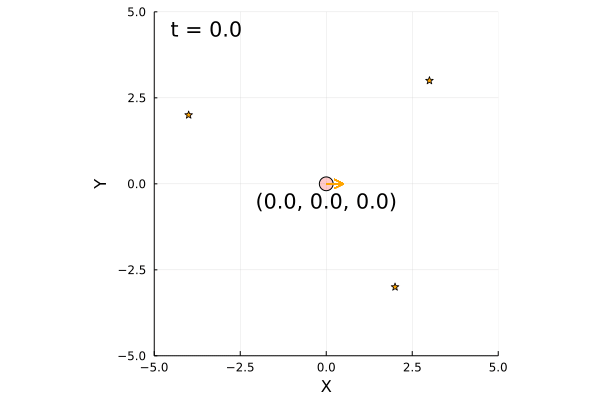

In [8]:
using .ResetMclWorld
using Distributions

function trial(animation=true)

    time_interval = 0.1    
    world = ResetMclWorld.World(30, 0.1)

    ### 地図を生成して2つランドマークを追加 ###
    m = ResetMclWorld.Map()
    ResetMclWorld.append(m, ResetMclWorld.TrueLandmark([-4, 2]))
    ResetMclWorld.append(m, ResetMclWorld.TrueLandmark([2, -3]))
    ResetMclWorld.append(m, ResetMclWorld.TrueLandmark([3, 3]))
    ResetMclWorld.append(world, m)

    initial_pose = [0.0, 0.0, 0.0]
    pf = ResetMclWorld.ResetMcl(initial_pose, 100, map=m)
    a = ResetMclWorld.EstimationAgent(time_interval, 0.2, 10.0/180.0*pi, pf)
    r = ResetMclWorld.RealRobot(initial_pose, :red, 0.2, a, sensor=ResetMclWorld.RealCamera(m), expected_kidnap_time=50.0)
    ResetMclWorld.append(world, r)

    if animation
        ResetMclWorld.draw(world)
    else
        ResetMclWorld.draw(world)
        return r.pose, pf.ml.pose
    end
end

trial()